## 1.1 Gini Index

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib import cm

# Define the Gini coefficient calculation function
def gini_coefficient(x):
    n = len(x)
    s = x.sum()
    r = np.argsort(np.argsort(-x))  # Calculates rank
    return 1 - (2 * (r * x).sum() + s) / (n * s)

In [2]:
# Load data
hospital_data = pd.read_csv('hospital_sum.csv')
pub_data = pd.read_csv('pub_sum.csv')
traffichub_data = pd.read_csv('traffichub_sum.csv')
workplace_data = pd.read_csv('workplace_sum.csv')

# Merging of data
merged_data = pd.merge(hospital_data, pub_data, on="category", suffixes=("_hospital", "_pub"))
merged_data = pd.merge(merged_data, traffichub_data, on="category")
merged_data = pd.merge(merged_data, workplace_data, on="category", suffixes=("_traffichub", "_workplace"))

In [3]:
# Calculating the Gini coefficient
merged_data['gini'] = merged_data[['mean_hospital', 'mean_pub', 'mean_traffichub', 'mean_workplace']].apply(gini_coefficient, axis=1)

In [4]:
# Loading geographic data
msoa_shapefile = gpd.read_file('MSOA_2011_London_gen_MHW.shp')
merged_map_data = msoa_shapefile.merge(merged_data, left_on="MSOA11CD", right_on="category", how='left')

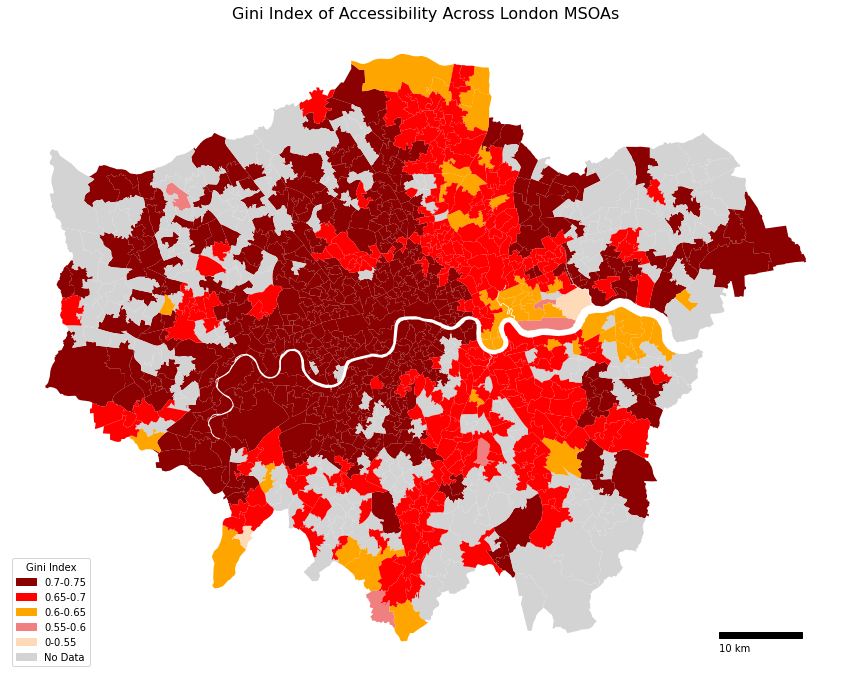

In [5]:
# Create 'gini_category' column based on 'gini' column value
def categorize_gini(gini_value):
    if pd.isna(gini_value):
        return 'No Data'
    elif gini_value <= 0.55:
        return '0-0.55'
    elif gini_value <= 0.6:
        return '0.55-0.6'
    elif gini_value <= 0.65:
        return '0.6-0.65'
    elif gini_value <= 0.7:
        return '0.65-0.7'
    elif gini_value <= 0.75:
        return '0.7-0.75'

# Applying Classification Functions
merged_map_data['gini_category'] = merged_map_data['gini'].apply(categorize_gini)

# Defining a colour dictionary
color_gradient_dict = {
    '0.7-0.75': 'darkred',
    '0.65-0.7': 'red',
    '0.6-0.65': 'orange',
    '0.55-0.6': 'lightcoral',
    '0-0.55': 'peachpuff',
    'No Data': 'lightgrey'
}

# Assigning colours to each category
for category, color in color_gradient_dict.items():
    merged_map_data.loc[merged_map_data['gini_category'] == category, 'color'] = color

# List of tags required to create a legend
legend_labels = list(color_gradient_dict.keys())


# Drawing Map
fig, ax = plt.subplots(figsize=(15, 15))
for color, data in merged_map_data.groupby('color'):
    data.plot(color=color, ax=ax)
    
# Adding headings and closing axes
ax.set_title('Gini Index of Accessibility Across London MSOAs', fontsize=16)
ax.axis('off')

# Creating Legends
legend_handles = [mpatches.Patch(color=color_gradient_dict[label], label=label) for label in legend_labels]
ax.legend(handles=legend_handles, title='Gini Index', loc='lower left')

# Add Scale
scalebar_right = mpatches.Rectangle((0.85, 0.05), 0.1, 0.01, transform=ax.transAxes, fill=True, color='black')
ax.add_patch(scalebar_right)
ax.text(0.85, 0.03, '10 km', transform=ax.transAxes, color='black')

plt.show()